# Project 2 - Classification and Regression

Team Members:
* Jeff Weltman
* Jordan Kassof
* Kevin Dickens

# 1. Data Preparation 1 
## Preparing Target Variables

In our classification task, we will be predicting a binary variable that indicates whether or not a highschool's average SAT score is considered "outperforming." This indicator variable is derived based on a threshold applied to the numeric average score. If a school's average SAT score is above 1080, for the purposes of this analysis, it is considered outperforming. While these classes aren't perfectly even, that is expected. It would be surprising to see an equal amount of outperforming and non-outperforming schools. The 262-159 class split isn't large enough for us to worry too much about class imbalance.

In [2]:
import numpy as np
import pandas as pd

# Initial dataset
hs_2017 = pd.read_csv("hs_2017.csv")

# Preparing the Classification variables
Y_class = hs_2017['sat_high_level']
X_class = hs_2017.drop(columns=['nc_district', 'sat_high_level', 'sat_avg_score_num'])

# Preparing the Regression variables
Y_reg = hs_2017['GraduationRate_5yr_All']
X_reg = hs_2017.drop(columns=['sat_high_level','sat_avg_score_num','lea_sat_avg_score_num'])

### Classification Variable

In our classification task, we will be predicting a binary integer variable that represents a one-hot encoding of whether or not a highschool's average SAT score "outperforms" expectations.  This indicator variable is derived based on a threshold applied to the numeric average score. If a school's average SAT score is above 1080, for the purposes of this analysis, it is considered outperforming. While these classes aren't perfectly even, that is expected. It would be surprising to see an equal amount of outperforming and non-outperforming schools. The 262-159 class split isn't large enough for us to worry too much about class imbalance.

In [3]:
import matplotlib.pyplot as plt

# Checking Classification Variable Balance
hs_2017.sat_high_level.value_counts().plot(kind='bar')
plt.title("Non-Outperform and Outperform Counts")
plt.ylabel("Number of Schools")
plt.show()
hs_2017.sat_high_level.value_counts()

<Figure size 640x480 with 1 Axes>

0.0    262
1.0    159
Name: sat_high_level, dtype: int64

### Regression Variable

In our regression task, we will be predicting the 5-year graduation rate for high schools in the public school system of North Carolina.  This variable represents the percentage of students graduating after five years and is stored as a floating point value.  This data was collected by the north carolina education department for the purpose of tracking school performance.  The distribution of the data follows a normal gaussian distribution although some 0 values are present which create a long tail.

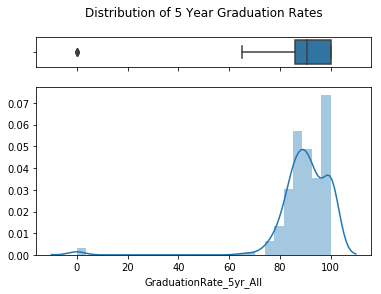

0    100.0
1     86.9
2     85.7
3     74.8
4     83.6
Name: GraduationRate_5yr_All, dtype: float64

In [4]:
#Checking  Regression Variable Distribution

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part

box = sns.boxplot(hs_2017["GraduationRate_5yr_All"], ax=ax_box)
dist = sns.distplot(hs_2017["GraduationRate_5yr_All"], ax=ax_hist)

box.set_title("Distribution of 5 Year Graduation Rates\n")

# Remove x axis name for the boxplot
ax_box.set(xlabel='')

plt.show()
hs_2017.GraduationRate_5yr_All.head()

### Scaling

In an attempt to correct distibution issues, we've scaled the data for both classification and regression tasks.

In [5]:
from sklearn.preprocessing import StandardScaler

# Standardize the data to a more normally distributed data
scaler_class = StandardScaler()
scaler_class.fit(X_class)

scaler_reg = StandardScaler()
scaler_reg.fit(X_reg)

StandardScaler(copy=True, with_mean=True, with_std=True)

# 2. Data Preparation 2
## Final Dataset

This dataset underwent preprocessing prior to this project.  As a result the quality and integrity were at suitably high levels for the project needs.  During that preprocessing many columns were removed if they contained more than 60% null values and null values were then imputed with zeros across the rest of the data.  In practice, most columns either held a large amount of NULL values or none at all.

For SAT data schools were removed if they did not report values either from masking due to low participation or actual no data available.

# 3. Modeling and Evaluation 1
## Evaluation Metrics
This section will discuss the measures of evaluation for both classification and regression tasks as well as define functions for use later in the code 

### Classification
For classification, we opted to use precision as our scoring metric. As we sought to most accurately predict whether a school would overperform on average SAT score, we concluded that minimizing false positives would be of greatest value. In our scenario, the risk of a false positive is great. A false positive would mean indicating a school is likely to outperform when it actually is not. If this model were being used to help direct funds to in-need schools, a false positive would result in a school who really needs help being passed over for additional funding. Conversely, a false negative, where a school is labeled as non-outperform when it actually is doing well doesn't have as high a cost. The school won't receive additional funding, but they don't need it anyway. 

Precision is defined as $\frac{TP}{TP+FP}$ where TP are true positives and FP are false positives. Looking at this formula, you can tell that precision optimizes for reducing false positives. As your FP value goes to 0, the precision score will approach 1 because the numerator and denomitor are equal.

Below we define a custom Classification Evaluation function, [created by Dr. Jake Drew](https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedHighSchoolCampuses.ipynb), to efficiently determine a given model's accuracy, precision, and recall. We will utilize this function to assess model performance in classifying whether a school is or is not overperforming.

In [6]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X, y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_Class, Y_Class, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)

Next we create a function to plot out the confusion matrix.

In [7]:
# Function modified from source here: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Regression
*Root Mean Squared Error* (RMSE) was utilized as our primary regression model's scoring criterion. This represented the degree to which our predicted model deviated from the actual data. It is widely used in regression task as a measurement of variance between the predicted and actual data and was therefore deemed the most appropriate metric for our regression tasks. RMSE is considered appropriate to represent model performance when the error distribution is normally distributed. 

In [8]:
from  sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

# Define function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#define Function for Mean Absolute Percentage Error (MAPE)
#From: https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/Graduation%20Rates%20February%202018%20-%205%20Years%20Expanded.ipynb
#Adapted from: https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y, y_pred): 
    mask = y != 0
    return (np.fabs(y - y_pred)/y)[mask].mean() * 100

#Scoring functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Array created to score individual folds
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }


def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    #From: https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/Graduation%20Rates%20February%202018%20-%205%20Years%20Expanded.ipynb
    #Adapted from: https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

# 4. Modeling and Evaluation 2
## Data Sampling Methodology

As the classification task's response variable is binary and not balanced - although, as mentioned above, the imbalance was not anticipated to be cause for concern - we used StratifiedShuffleSplit for classification. This ensured that each of the 10 folds would include an overperforming and non-overperforming school. Best results for this stratified 10-fold cross-validation included an 80/20 train-test split.

In [9]:
#Divide data into test and training splits
from sklearn.model_selection import StratifiedShuffleSplit

cv_class = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

For the regression tasks, we employed the ShuffleSplit cross-validation with 10 folds to thoroughly randomize our sampling. We found that a 60/40 train/test split yielded the best results for each of our regression tasks.

In [10]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit

cv_reg = ShuffleSplit(n_splits=10, test_size=0.40, random_state=0)

# 5. Modeling and Analysis
## Classification Tasks
We look at three different classification tasks for this project:

* Logistic Regression
* K Nearest Neighbors
* Random Forest

## Logistic Regression
Logistic Regression is a common form of classification for dichotomous variables.  It performs the predictive analysis by estimating the log odds of an event and assigning a binary 1 or 0 dependant upon those log odds.  For logistic regression to effectively classify these values the data shouldn't contain large outliers and no multicollinearity should be present amongst the predictors.

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv_class, scoring='precision')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_class, Y_class)

#display the best pipeline model identified during the grid search
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.001, class_weight='none', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [33]:
EvaluateClassifierEstimator(grid.best_estimator_, X_class, Y_class, cv_class)

The average accuracy for all cv folds is: 			 0.85765
The average precision for all cv folds is: 			 0.87108
The average recall for all cv folds is: 			 0.72813
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.835294,0.846154,0.68750
1,0.847059,0.880000,0.68750
2,0.835294,0.875000,0.65625
3,0.894118,0.896552,0.81250
4,0.905882,0.875000,0.87500
5,0.882353,0.923077,0.75000
6,0.905882,0.900000,0.84375
7,0.800000,0.826087,0.59375
8,0.800000,0.800000,0.62500
9,0.870588,0.888889,0.75000


## K Nearest Neighbors
K-Neighbors classifiers measure the distance between points according to a supplied distance metric. Once that distance is calculated, the nearest points - a number of which is identified by the variable *k* - are compared with the current point.  
  
We utilized a cross-validated GridSearch to obtain the best combination of parameters out of 290 potential models.

In [16]:
#KNN 10-fold cross-validation 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import jaccard
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')

knc = KNeighborsClassifier(n_neighbors=5)
knn_pipe = make_pipeline(StandardScaler(), knc)


k_range = list(range(1, 30))
metrics = ['euclidean','chebyshev','manhattan','minkowski','jaccard']
weights_options = ['uniform','distance']

knn_parameters = {'kneighborsclassifier__n_neighbors': k_range,'kneighborsclassifier__weights': weights_options, 'kneighborsclassifier__metric': metrics}

#Create a grid search object using the defined parameters

kGridSearch = GridSearchCV(knn_pipe,param_grid=knn_parameters,n_jobs=4,verbose=1,cv=cv_class,scoring='precision')

#Perform hyperparameter search to find the best combination of parameters for our data
kGridSearch.fit(X_class, Y_class)

Fitting 10 folds for each of 290 candidates, totalling 2900 fits


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 353 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 1097 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 2497 tasks      | elapsed:   46.5s
[Parallel(n_jobs=4)]: Done 2893 out of 2900 | elapsed:   56.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 2900 out of 2900 | elapsed:   57.1s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'kneighborsclassifier__weights': ['uniform', 'distance'], 'kneighborsclassifier__metric': ['euclidean', 'chebyshev', 'manhattan', 'minkowski', 'jaccard']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=1)

In [17]:
#Diplay the top model parameters
# kGridSearch.best_params_
kGridSearch.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=28, p=2,
           weights='uniform'))])

In [18]:
EvaluateClassifierEstimator(kGridSearch.best_estimator_, X_class, Y_class, cv_class)

The average accuracy for all cv folds is: 			 0.82235
The average precision for all cv folds is: 			 0.8736
The average recall for all cv folds is: 			 0.61562
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.788235,0.888889,0.50000
1,0.800000,0.857143,0.56250
2,0.788235,0.850000,0.53125
3,0.882353,0.923077,0.75000
4,0.847059,0.851852,0.71875
5,0.823529,0.869565,0.62500
6,0.894118,0.925926,0.78125
7,0.752941,0.823529,0.43750
8,0.788235,0.888889,0.50000
9,0.858824,0.857143,0.75000


### Random Forest

The Random Forest is a relatively new machine learning algorithm, invented in the 1990s. It is an ensemble method extension of the decision tree. As an extension of decision trees, random forests can be used for both classification and regression. We will be focusing exclusively on classification random forests, but most commentary can be applied to both types of random forests. 

In the random forest algorithm, you take a random subset of your data's features, grow a shallow decision tree, take note of the predicted class, then repeat that process over and over. The class that is predicted most often by all of the decision trees is the output of the random forest. Given the above description, there are **three primary parameters** available to optimize the algorithm. 

- **n_features:** This parameter indicates the number of random features to select from the full dataset for each tree in the forest. This can either be a specific number, or a selection method.
- **max_depth:** This parameter drives the maximum depth of any of the decision trees grown
- **n_estimators:** The number of trees to grow

Below is a visual explanation for how the 3 parameters affect a random forest , with the names of the parameters highlighted in red.

<center><img src='random_forest.png' width = '75%'></center>

There are actually several other parameters available when growing a random forest, they are mostly related to the details of how each individual decision tree is grown. These parameters include the metric used for node splitting (gini impurity or entropy), the minimum number of samples required to split a node, the minimum impurity decrease to split a node, and others.

Below we will grow a random forest using the default parameters, and examine the resulting model's quality based on previous discussed metrics. To get a sense for out-of-sample error, we will break out 20% of our data and only use that for testing.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, recall_score, f1_score

# Generate a 60/40 training/test split of data
X_train, X_test, y_train, y_test = train_test_split(X_class, Y_class, test_size=0.2, random_state=0)

# Generate & train instance of RandomForest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

EvaluateClassifierEstimator(rf, X_class, Y_class, cv_class)

The average accuracy for all cv folds is: 			 0.84706
The average precision for all cv folds is: 			 0.84117
The average recall for all cv folds is: 			 0.73125
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.811765,0.766667,0.71875
1,0.811765,0.833333,0.62500
2,0.847059,0.880000,0.68750
3,0.905882,0.875000,0.87500
4,0.835294,0.846154,0.68750
5,0.870588,0.862069,0.78125
6,0.917647,0.903226,0.87500
7,0.811765,0.807692,0.65625
8,0.847059,0.851852,0.71875
9,0.811765,0.785714,0.68750


As we can see, the average precision for our cross validated models is .84, respectable but not as good as the logistic regression or knn examples above. Another great evaluation of the model is to use it on data it has never seen before. We'll do that by calculating the relevant statistics for our predictions on the hold out 20% of data.

Precision: 0.9310
Accuracy: 0.8941
Recall: 0.7941


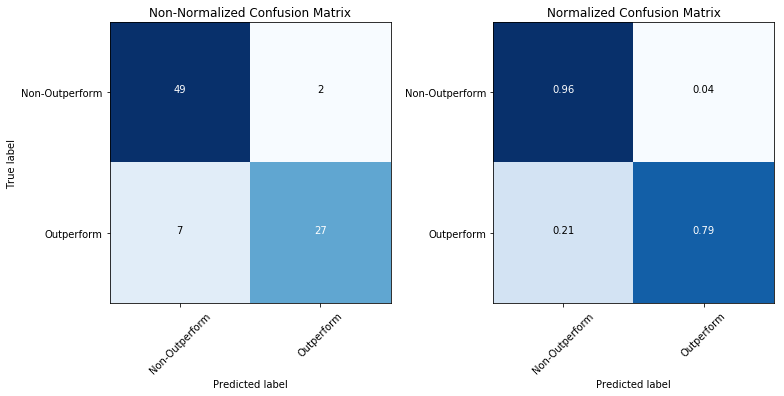

In [14]:
# Print classification metrics & confusion matrix (normalized & non)
print("Precision: %0.4f" % precision_score(y_test, rf.predict(X_test)))
print("Accuracy: %0.4f" % accuracy_score(y_test, rf.predict(X_test)))
print("Recall: %0.4f" % recall_score(y_test, rf.predict(X_test)))

rf_precision = precision_score(y_test, rf.predict(X_test))
rf_recall = recall_score(y_test, rf.predict(X_test))
rf_accuracy = accuracy_score(y_test, rf.predict(X_test))

# Calc and plot confusion matrices
cm = confusion_matrix(y_test, rf.predict(X_test))
plt.figure(figsize = (11, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'])
plt.title("Non-Normalized Confusion Matrix")
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'], normalize=True)
plt.title("Normalized Confusion Matrix")
plt.ylabel("")
plt.show()

When we apply the random forest model to a set of records it has never seen before, we get a .93 precision, the highest so far.  Random forest is a very popular algorithm because it tends to produce pretty high quality results, even without hyperparameter tuning. As we can see in the top row of the confusion matrix, out of the 51 non-outperforming schools, we correctly identified 96% of them. This statistic, the percentage of correctly identified negative results is called the **specificity**.


## Regression Tasks
We look at three different regression tasks for this project:

* Ordinary Least Squares (OLS)
* Least Absolute Shrinkage and Selection Operation (LASSO)
* Huber Regression

### Ordinary Least Squares (OLS)

Oridinary Least Squares (OLS) Regression is the standard form of regression well known to students, academics, and industry professionals alike. While it isn't cutting edge, it's a powerful technique used by a huge number of statisticians and data scientists, and always a great place to start a regression analysis. In OLS regression we attempt to estimate the parameters in a linear model by minimizing the sum of squared residuals.

In [25]:
from  sklearn.model_selection  import train_test_split
from sklearn import linear_model, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

lr = linear_model.LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

R2: -14.02 (+/- 16.38)


In [37]:
#Create a Regression Object and find parameters
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

#Test parameters 
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

regGridSearch = GridSearchCV(estimator=lr
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_reg # KFolds = 10
                   , scoring=mae_scorer)

regGridSearch.fit(X_reg, Y_reg)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.4, train_size=None),
       error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'normalize': (True, False), 'fit_intercept': (True, False)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [38]:
#Print the parameterization of the best estimator
regGridSearch.best_estimator_

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

In [39]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_reg, Y_reg, cv_reg)

The average MAE for all cv folds is: 			 0.03318
The average MAE percentage (MAPE) for all cv folds is: 	 0.034284
The average RMSE for all cv folds is: 			 0.051309
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.047861,0.044743,0.090258
1,0.052972,0.054798,0.075613
2,0.024444,0.026290,0.035309
3,0.030778,0.032761,0.043065
4,0.040969,0.040749,0.060197
5,0.026052,0.026519,0.043416
6,0.019363,0.021064,0.026187
7,0.024886,0.026378,0.038286
8,0.049984,0.053796,0.080731
9,0.014493,0.015747,0.020025


## LASSO Regression
Least Absolute Shrinkage and Selection Operator (LASSO) is a method of linear regression that uses shrinkage to reduce the dimensionality to create a more parsimonious model that best describes the relationship to the predicted variable.  LASSO introduces bias to the model as a penalty to the absolute value of the magnitude of the coefficients.  This bias penalty is aimed at reducing the size of the model to create the simplest model possible.  Thus LASSO is typically far easier to interpret than most other regression models.

In [29]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, alpha=0.001, max_iter=100)

#Test parameters 
alpha_options = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.05, 0.01]
warm_start = [True, False]
fit_intercept = [True, False]
parameters = {'alpha': alpha_options, 'warm_start': warm_start, 'fit_intercept': fit_intercept}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
LassoGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=4 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_reg # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
LassoGridSearch.fit(X_reg, Y_reg)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done 104 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:    3.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.4, train_size=None),
       error_score='raise',
       estimator=Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.05, 0.01], 'warm_start': [True, False], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [30]:
#Display the best estimator parameters#Display  
LassoGridSearch.best_estimator_

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=100,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=True)

In [31]:
#Create a regression estimator with best parameters for cross validation
LassoEstimator = LassoGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(LassoEstimator, X_reg, Y_reg, cv_reg)

The average MAE for all cv folds is: 			 0.77457
The average MAE percentage (MAPE) for all cv folds is: 	 0.81824
The average RMSE for all cv folds is: 			 1.1089
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,0.977529,0.998071,1.439422
1,0.894286,0.934199,1.354613
2,0.643887,0.690721,0.908935
3,0.825888,0.877348,1.188978
4,0.591162,0.596215,0.855559
5,0.702421,0.722877,1.082895
6,0.762213,0.845338,1.047530
7,0.808219,0.847123,1.204811
8,0.677894,0.711271,0.905091
9,0.862196,0.959211,1.101424


## Huber Regression
The Huber Regression model was selected as a regression model due to its being robust to outliers. We performed a grid search to determine the optimal epsilon - which measures the robustness to outliers - as well as alpha, the regularization parameter. This yielded 560 possible combinations of models.

In [24]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import HuberRegressor 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline

reg = HuberRegressor(epsilon=1.50,fit_intercept=True, alpha=0.001, max_iter=100)
# top_feat = SelectKBest(score_func=chi2, k=75)

# pipe = Pipeline([('feature', top_feat), ('huber',reg)])

#Test parameters 
epsilon_range = np.arange(1.0, 2.0, 0.05)
alpha_options = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.05, 0.01]
warm_start = [True, False]
fit_intercept = [True, False]
parameters = {'epsilon': epsilon_range, 'alpha': alpha_options, 'warm_start': warm_start, 'fit_intercept': fit_intercept}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
HuberGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=2 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_reg # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data

HuberGridSearch.fit(X_reg, Y_reg)

Fitting 10 folds for each of 560 candidates, totalling 5600 fits


[Parallel(n_jobs=2)]: Done  71 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done 371 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done 871 tasks      | elapsed:   33.4s
[Parallel(n_jobs=2)]: Done 1571 tasks      | elapsed:   59.4s
[Parallel(n_jobs=2)]: Done 2471 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 3571 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done 4871 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 5597 out of 5600 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done 5600 out of 5600 | elapsed:  3.5min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.4, train_size=None),
       error_score='raise',
       estimator=HuberRegressor(alpha=0.001, epsilon=1.5, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'epsilon': array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
       1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95]), 'alpha': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.05, 0.01], 'warm_start': [True, False], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [25]:
#Display the best estimator parameters
HuberGridSearch.best_estimator_

HuberRegressor(alpha=0.05, epsilon=1.9000000000000008, fit_intercept=False,
        max_iter=100, tol=1e-05, warm_start=True)

In [26]:
#Create a regression estimator with best parameters for cross validation
HuberregEstimator = HuberGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(HuberregEstimator, X_reg, Y_reg, cv_reg)

The average MAE for all cv folds is: 			 6.7332
The average MAE percentage (MAPE) for all cv folds is: 	 6.379
The average RMSE for all cv folds is: 			 12.086
*********************************************************
Cross Validation Fold Mean Error Scores


,MAE,MAPE,RMSE
0,7.207059,6.533801,13.445778
1,6.864356,6.576511,12.737812
2,6.402806,6.600874,10.310756
3,7.355837,6.660856,13.292888
4,7.404944,6.644391,14.352779
5,6.085067,5.386153,11.906259
6,6.014118,6.297595,9.230502
7,7.622230,6.868554,14.106941
8,6.416503,6.037579,11.745375
9,5.959206,6.183579,9.735045


# 6. Data and Evaluation 4
## Results - Classification



# 7. Data and Evaluation 5
## Advantages and Disadvantages

The below table provides the conceptual advantages and disadvantages of the various classification and regression techniques used throughout this analysis. Below that we will statistically analyze which models performed best.

</center><img src = 'proscons.png'></center>

In order to compare these models, we first have to remember that whenever we conduct these analyses we are only looking at a **sample** and not the entire population. That means that if we drew a different set of North Carolina schools, we would have different evaluation metrics. 

In [79]:
# Comparing KNN, Logistic, and Random Forest

# Assume that accuracy is binomially distributed, error = 1-accuracy
acc_log = 0.85765
acc_knn =  0.82235
acc_rf = 0.8941
e_log = 1 - acc_log
e_knn = 1- acc_knn
e_rf = 1 - acc_rf


# For binom dist. define variance of binomial distribution as error*(1-error)/#sampples
def calc_var(e, n):
    return (e*(1-e))/n

# Calc variance for 3 model types based on accuracy
var_log = calc_var(e_log, X_class.shape[0])
var_knn = calc_var(e_log, X_class.shape[0])
var_rf = calc_var(e_log, X_train.shape[0])

# Calc 95% CI for difference between two distributions
def calc_95ci(e1, e2, var1, var2):
    return [(e1-e2)-1.96*np.sqrt(var1+var2), (e1-e2)+1.96*np.sqrt(var1+var2)]   

log_v_knn = calc_95ci(e_log, e_knn, var_log, var_knn)
log_v_rf = calc_95ci(e_log, e_rf, var_log, var_rf)
knn_v_rf = calc_95ci(e_knn, e_rf, var_knn, var_rf)

# Print out results based on accuracy
print('The confidence interval for log - knn is: ', np.around(log_v_knn,4))
print('The confidence interval for log - random forest is: ', np.around(log_v_rf,4))
print('The confidence interval for knn - random forest is: ', np.around(knn_v_rf, 4))

The confidence interval for log - knn is:  [-0.0825  0.0119]
The confidence interval for log - random forest is:  [-0.0136  0.0865]
The confidence interval for knn - random forest is:  [0.0217 0.1218]


The two above confidence intervals which contain 0 indicate that with 95% confidence we can state there is not a statistically significant difference in the performance of logistic model when compared to knn or random forest. On the other hand, we see a confidence interval completely above 0 when comparing KNN to Random Forest. This indicates that KNN has a statistically significantly **higher error rate** i.e. **lower accuracy** than the random forest.

# 8. Data and Evaluation 6
## Most Important Attributes

### Regression models

We examined the coefficients of the Huber Regression model and LASSO to determine which attributes were the most important.  Surprisingly the top 10 important features came back identical.

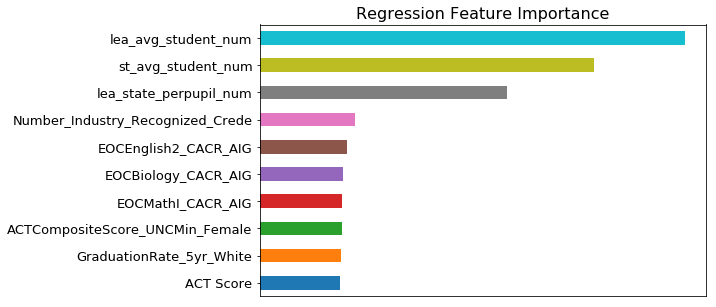

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

huber_imps = pd.DataFrame({"feature":X_reg.columns})
huber_imps['fscore'] = np.transpose(HuberGridSearch.best_estimator_.coef_.ravel())
huber_imps['fscore'] = huber_imps['fscore'] / huber_imps['fscore'].max()
huber_imps.sort_values('fscore', ascending = False, inplace = True)
huber_imps = huber_imps[0:10]
huber_imps.sort_values('fscore', ascending = True, inplace = True)
huber_imps.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(8, 5))
plt.title('Regression Feature Importance', fontsize = 16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks(fontsize=13)
plt.show()

When examining the ten most important features of the Regression models, we can see from the top four features that graduation rate is influenced largely simply by the number of students at the school compared to the district (lea) and state level. This follows logically, as a school's relative student population size will be a contributing factor to the percentage of that population which graduates. Five of the six remaining features in the top 10 are derived from end of course scores or ACT score-related attributes, as positive results in these academic areas should be reflected by a stable or increasing graduation rate. Lastly, the fifth-most important feature is *Number_Industry_Recognized_Crede*. This is the industry-recognized credentials earned by students, which is also an identifier of academic success and therefore logically translates to graduation rate.

### K-Nearest Neighbors

Feature importance cannot be as easily ascertained for K-Neighbors classifiers. These classifiers compute distance and look to nearby points to determine class label. Our research indicated that utilizing alternative methods, such as simulated annealing, might be able to yield useful insight in this regard, but with the computational expense being greater than the benefit of the obtained information. See the following R-bloggers article for a lengthier explanation and a demonstration of this in R: https://www.r-bloggers.com/simulated-annealing-feature-selection/

### Random Forests

Random Forests are most predictive, not descriptive. You cannot interpret a random forest the way you do a regression model and understand the relationship between each covariate and the target variable. That being said, you can extract relative feature importance to gain insight into what features drive predictions. Below we will do that for out earlier random forest.

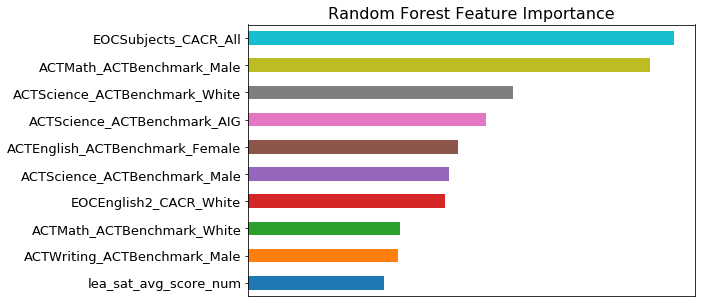

In [39]:
var_imps = pd.DataFrame(X_class.columns, columns = ['feature'])
var_imps['fscore'] = rf.feature_importances_[:,]
var_imps['fscore'] = var_imps['fscore'] / var_imps['fscore'].max()
var_imps.sort_values('fscore', ascending = False, inplace = True)
var_imps = var_imps[0:10]
var_imps.sort_values('fscore', ascending = True, inplace = True)
var_imps.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(8, 5))
plt.title('Random Forest Feature Importance', fontsize = 16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([], [])
plt.yticks(fontsize=13)
plt.show()

In the above plot we can see that the driving features of our model are a handful of other performance measures. EOC scores are the equivalent of final exams (end of course exams) and the ACT is another major national college entrance exam. It isn't too surprising to see all of these variables provide strong clues towards whether or not a school will outperform on the SAT.

# 9. Deployment

The models evaluated in this project would likely prove useful to policy-makers, non-profits, and businesses seeking to target low-performing schools for aid and services.  The  data used by the model is publicly available, albeit with necessary cleanup and precisely classifies successful SAT schools and predicts graduation rates.  It is likely that these interested parties would also be interested in the prevalence and the specificity.  Prevalence indicates how frequently school's overperforming actually occurs.  Specificity is how frequently the model accurately predicts an underperforming school.  Prevalence could be broke up by school district to see an overall success rate for the distict while specificity can be used to accurately show schools in need of serious help.
   
This dataset could benefit from additional data that could provide trend analysis and additional context to individual schools and school districts.  The data could be merged with previous years data to allow for trend analysis via a time series.  This could drive predictions about whether a school can sustain the level of academic success expected or aid in detecting schools at risk.  The current dataset focuses entirely on intneral school performance indicators but gives little context about external factors that may affect school performance.  Data on levels of poverty, crime, and economic indicators for the surrounding community of each school or school district could assist policy makers with targeting aid programs intended to help low-income students or where additional security funding is necessary due to high crime.
   
The model should be updated on an annual basis along with the new data that is generated for the school report cards.  This would allows for new data to be gathered by the state and analyzed and schools to implement changes over the course of an academic year.  Additionally, since the data is only reported on a yearly basis, any model updates generated in the interim would use the same data and likely show similar results to the prior analyses.

In order to understand the long-term effectiveness of this model as a tool, we would want to see the schools who are targeted as non-outperforming, and thus receive dollars, increase their average SAT numeric score, and hopefully move from non-outperform to outperform.

# 10. Exceptional Work

## Random Forest Grid Search

In the earlier random forest model, we used the default parameters provided by `scikit-learn`, but those are not necessarily optimal. The defaults for the main parameters are as follows: n_estimators=10, criterion=gini, max_features=auto, max_depth=none. Using the default parameters for a powerful algorithm like random forest is the equivalent of buying a 65 inch 4K HDTV, then playing a regular DVD on it, you're going to get great results, but not the best money can buy.

While it's good we have "knobs" to turn on the algorithm, it can be daunting to come up with the optimal set of parameters. Where to start? One option is grid search. In grid search, you take the cartesian product for a set of possible parameter values, and re-run your model for each set of parameters. One of those sets of parameters will have best results, and that is your result. The downside of this approach is that the number of iterations can grow very quickly as you increase the number of parameters & options in your grid, increasing the computational overhead of the model building. Secondly, this method does not guarantee arriving at a global maximum. With those caveats in mind, let's see if/by how much we can increase our model quality.

In [40]:
# Define options for various parameters in model
param_grid = {
    'n_estimators': [5, 25, 100, 150],
    'max_depth':    [int(i) for i in range(2,11)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion':    ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 6, 8]
}

# Generate & fit RandomForest with grid search per the above
from sklearn.model_selection import GridSearchCV

rfgc = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_rf = GridSearchCV(rfgc, param_grid, cv=10, scoring="precision")

# Careful with the below line of code, it can take a long time to run. It has been commented
# out to prevent accidental running

grid_rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [10]:
print("\n\n Parameters from best model:\n", grid_rf.best_params_)
print("\nPrecision: %0.2f" % precision_score(y_test, grid_rf.predict(X_test)))
print("Accuracy: %0.2f" % accuracy_score(y_test, grid_rf.predict(X_test)))
print("Recall: %0.2f" % recall_score(y_test, grid_rf.predict(X_test)))

crit = 'gini'
max_depth = 7
max_features = 'auto'
min_samples_leaf = 4
n_estimators = 100

rf_gc_params = RandomForestClassifier(random_state=42, criterion='gini', min_samples_leaf=4,
                                      n_estimators=100, max_features='auto')
rf_gc_params.fit(X_train, y_train)

cm = confusion_matrix(y_test, grid_rf.predict(X_test))
plt.figure(figsize = (11, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'])
plt.title("Non-Normalized Confusion Matrix")
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'], normalize=True)
plt.title("Normalized Confusion Matrix")
plt.ylabel("")
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

Our grid search took overnight to complete, but yielded barely better results than our default random forest. This goes to show one of the biggest strenghts of the random forest algorithm, it performs very well out-of-the-box. While it is possible to get better results by optimizing hyperparameters, they aren't likely to be significantly better, which is an important factor in many applications. If eeking out every last possible drop of accuracy is important, running models overnight may be worth the trouble, but in many applications a random forest with default parameters may just be "good enough." 

### Scaling Pipeline

Although the StandardScaler was used above to normalize the data, that operates under the assumption that the data in our set is well-suited to a standard normal distribution. We therefore combined a **for** loop with a Pipeline to cycle through the data utilizing different scalers.

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer
#KNN 10-fold cross-validation 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import jaccard
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')

class_cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

knc = KNeighborsClassifier(n_neighbors=5)

scales = {RobustScaler(quantile_range=(25, 75)),
         StandardScaler(),
         MinMaxScaler(),
         MaxAbsScaler(),
         QuantileTransformer(output_distribution='uniform'),
         QuantileTransformer(output_distribution='normal'),
         Normalizer()}

k_range = list(range(1, 30))
metrics = ['euclidean','chebyshev','manhattan','minkowski','jaccard']
weights_options = ['uniform','distance']

knn_parameters = {'kneighborsclassifier__n_neighbors': k_range,'kneighborsclassifier__weights': weights_options, 'kneighborsclassifier__metric': metrics}

#Create a grid search object using the defined parameters
for i in scales:
    scaled_knn_pipe = make_pipeline(i, knc)
    kGridSearch = GridSearchCV(scaled_knn_pipe,param_grid=knn_parameters,n_jobs=4,verbose=1,cv=class_cv,scoring='precision')

#Perform hyperparameter search to find the best combination of parameters for our data
kGridSearch.fit(X_class, Y_class)

Fitting 10 folds for each of 290 candidates, totalling 2900 fits


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 353 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 1097 tasks      | elapsed:   20.5s
[Parallel(n_jobs=4)]: Done 2497 tasks      | elapsed:   47.0s
[Parallel(n_jobs=4)]: Done 2893 out of 2900 | elapsed:   57.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 2900 out of 2900 | elapsed:   57.6s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'kneighborsclassifier__weights': ['uniform', 'distance'], 'kneighborsclassifier__metric': ['euclidean', 'chebyshev', 'manhattan', 'minkowski', 'jaccard']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=1)

In [39]:
kGridSearch.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=26, p=2,
           weights='uniform'))])

In [40]:
EvaluateClassifierEstimator(kGridSearch.best_estimator_, X_class, Y_class, cv_class)

The average accuracy for all cv folds is: 			 0.81882
The average precision for all cv folds is: 			 0.86533
The average recall for all cv folds is: 			 0.6125
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.788235,0.888889,0.50000
1,0.800000,0.857143,0.56250
2,0.788235,0.850000,0.53125
3,0.870588,0.862069,0.78125
4,0.847059,0.880000,0.68750
5,0.823529,0.869565,0.62500
6,0.894118,0.925926,0.78125
7,0.752941,0.823529,0.43750
8,0.788235,0.850000,0.53125
9,0.835294,0.846154,0.68750


The GridSearch determined that the best scaler to use with K-Nearest Neighbors and our data set was a normally distributed quantile transformed scaler. Although precision and accuracy both decreased slightly compared to the standard scaled model above, the recall increased by over 10%. This is indicative of a more balanced model overall.